# Machine learning with the Open Data Cube - modified <img align="right" src="../Supplementary_data/dea_logo.jpg">

* [**Sign up to the DEA Sandbox**](https://docs.dea.ga.gov.au/setup/sandbox.html) to run this notebook interactively from a browser
* **Compatibility:** Notebook currently compatible with both the `NCI` and `DEA Sandbox` environments
* **Products used:** 
[ga_ls8c_nbart_gm_cyear_3](https://explorer.sandbox.dea.ga.gov.au/ga_ls8c_nbart_gm_cyear_3)
* **Special requirements:** A shapefile of labelled data in shapefile format is required to use this notebook.
An example dataset is provided.
* **Prerequisites:** A basic understanding of supervised learning techniques is required. 
[Introduction to statistical learning](https://doi.org/10.1007/978-1-4614-7138-7) is a useful resource to begin with - it can be downloaded for free [here](http://faculty.marshall.usc.edu/gareth-james/ISL/ISLR%20Seventh%20Printing.pdf). 
The [Scikit-learn](https://scikit-learn.org/stable/supervised_learning.html) documentation provides information on the available models and their parameters.


## Description

This notebook demonstrates a potential workflow using functions from the [dea_tools.classification](../Tools/dea_tools/classification.py) script to implement a supervised learning landcover classifier within the [ODC (Open Data Cube)](https://www.opendatacube.org/) framework. 

For larger model training and prediction implementations this notebook can be adapted into a Python file and run in a distributed fashion.

This example predicts a single class of cultivated / agricultural areas.
The notebook demonstrates how to:

1. Extract the desired ODC data for each labelled area (this becomes our training dataset).
2. Train a simple decision tree model and adjust parameters. 
3. Predict landcover using trained model on new data.
4. Evaluate the output of the classification using quantitative metrics and qualitative tools.

> This is a quck reference for machine learning on the ODC captured in a single notebook. For a more indepth exploration please use the [Scalable Machine Learning](../Real_world_examples/Scalable_machine_learning/0_README.ipynb) series of notebooks.
***

## Getting started

To run this analysis, run all the cells in the notebook, starting with the "Load packages" cell. 

### Load packages
Import Python packages that are used for the analysis.

In [1]:
%matplotlib inline

import subprocess as sp
import shapely
import xarray as xr
import rasterio
import datacube
import matplotlib
import pydotplus
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
from io import StringIO
from odc.io.cgroups import get_cpu_quota
from sklearn import tree
from sklearn import model_selection
from sklearn.metrics import accuracy_score
from IPython.display import Image
from datacube.utils import geometry
from datacube.utils.cog import write_cog

import sys
sys.path.insert(1, '../Tools/')
from dea_tools.classification import collect_training_data, predict_xr

import warnings
warnings.filterwarnings("ignore")

In [2]:
import pandas as pd

### Connect to the datacube

Connect to the datacube so we can access DEA data.

In [3]:
dc = datacube.Datacube(app='Machine_learning_with_ODC')

### Analysis parameters
* `path`: The path to the input shapefile. A default shapefile is provided.
* `field`: This is the name of column in your shapefile attribute table that contains the class labels
* `time`: The time range you wish to extract data for, typically the same date the labels were created.
* `zonal_stats`: This is an option to calculate the `'mean'`, `'median'`, or `'std'` of the pixel values within each polygon feature, setting it to `None` will result in all pixels being extracted.
* `resolution`: The spatial resolution, in metres, to resample the satellite data too e.g. if working with Landsat data, then this should be `(-30, 30)`
* `output_crs`: The coordinate reference system for the data you are querying.
* `ncpus`: Set this value to > 1 to parallize the collection of training data. eg. `npus=8`

**If running the notebook for the first time**, keep the default settings below. This will demonstrate how the analysis works and provide meaningful results.  


In [4]:
path = 'roi_1023.shp'  # make sure this points to your shapefile!!
field = 'CLASS_ID'  # checked the cols beforehand (this is a standard output name from ENVI)
time = ("2022-01-01", "2022-03-01")
zonal_stats = 'median'
resolution = (-30, 30)
output_crs = 'EPSG:3577'  # lat lon

### Automatically detect the number of cpus

In [5]:
ncpus=round(get_cpu_quota())
print(ncpus)

2


### Preview input data and study area

We can load and preview our input data shapefile using `geopandas`.
The shapefile should contain a column with class labels (e.g. `classnum` below).
These labels will be used to train our model.

In [6]:
# Load input data shapefile
input_data = gpd.read_file(path)

# Plot first five rows
input_data.head()

,CLASS_ID,CLASS_NAME,AREA,geometry
0,4,Forest,42.0,"POLYGON ((1105280.000 7018920.000, 1105210.000..."
1,2,Urban/Bareground,30.0,"POLYGON ((1108580.000 7018890.000, 1108530.000..."
2,1,Water,18.0,"POLYGON ((1107690.000 7018700.000, 1107660.000..."
3,3,Grassland,24.0,"POLYGON ((1107320.000 7018450.000, 1107310.000..."
4,2,Urban/Bareground,20.0,"POLYGON ((1108710.000 7017970.000, 1108670.000..."


In [7]:
input_data.CLASS_ID = pd.to_numeric(input_data.CLASS_ID)  
# change the datatype to integer

In [8]:
# Load input data shapefile
# input_data = gpd.read_file(path)

# # Plot first five rows
# input_data.head()

The data can also be explored using the interactive map below.
Hover over each individual feature to see a print-out of its unique class label number above the map.

In [9]:
# Plot training data in an interactive map
input_data.explore(column=field, legend=False)

## Extract training data using a shapefile

To train our model, we need to obtain satellite data that corresponds with the labelled input data locations above. 
The function below takes our shapefile containing class labels and extracts the specified product within these areas into a single array.

In [10]:
# Generate a new datacube query object
query = {
    'time': time,
    'resolution': resolution,
    'output_crs': output_crs,
    'group_by': 'solar_day',
}

The following function is passed to `collect_training_data`. 

It extracts bands from the [ga_ls8c_nbart_gm_cyear_3](https://explorer.sandbox.dea.ga.gov.au/products/ga_ls8c_nbart_gm_cyear_3) product as feature layers along side our labelled data so we can train a supervised model.

The feature function can be modified to extract different combinations of features within the datacube, it is one of the important parts to experiment with when generating your own model.

In [11]:
def custom_function(query):

    # Initialise datacube
    dc = datacube.Datacube(app='custom_feature_layers')

    # Load data using query
    result = dc.load(product='ga_ls8c_nbart_gm_cyear_3', **query)

    return result

> **Note:** The following cell can take several minutes to run. The class labels will be contained in the first column of the output array called model_input, the corresponding variable names captured in the list column_names

In [12]:
column_names, model_input = collect_training_data(gdf=input_data,
                                                  dc_query=query,
                                                  ncpus=ncpus,
                                                  feature_func=custom_function,
                                                  field=field,
                                                  zonal_stats=zonal_stats)

Taking zonal statistic: median


  0%|          | 0/52 [00:00<?, ?it/s]

Percentage of possible fails after run 1 = 1.92 %
Removed 1 rows wth NaNs &/or Infs
Output shape:  (51, 11)


In [13]:
# visualise the results as a dataframe

training_data_df = pd.DataFrame(columns=column_names,data=model_input)
training_data_df.head()

,CLASS_ID,blue,green,red,nir,swir1,swir2,sdev,edev,bcdev,count
0,4.0,244.0,378.0,321.5,2269.5,966.0,433.0,0.001628,199.805603,0.040281,8.0
1,1.0,257.0,258.0,222.0,284.5,219.0,170.5,0.004734,164.981110,0.130028,10.0
2,3.0,551.0,903.0,791.0,3773.0,2537.0,1299.0,0.002782,481.169037,0.039739,11.0
3,2.0,1110.0,1330.0,1324.0,2801.0,2493.0,1886.0,0.000799,531.506775,0.047864,10.0
4,3.0,590.0,1020.0,868.5,4524.5,2907.5,1624.0,0.005165,774.287537,0.061370,11.0


## Preprocessing

In [14]:
""" this stage will depend on if you want to modify your training data """

' this stage will depend on if you want to modify your training data '

Our training data has multiple classes in it.
However, we are only trying to predict one class (i.e. class label 111, _Cultivated Terrestrial Vegetated_) with this model. 
We therefore remove other classes from our training data by setting the label value for all other classes to 0.

These entries provide counter-examples to help the model distinguish the landcover classes from each other.

In [15]:
# # Modify the input training data for single class labels
# model_input[:, 0] = np.where(model_input[:, 0] == 111, 1, 0)

So that we can access the accuracy of our classification, we split our data into training and testing data. 
80% is used for training with 20% held back for testing.
When splitting our data, we stratify the training data by the distributions of class membership.
This sampling method leads to a similar distribution of class membership in the training data.

In [16]:
# # Split into training and testing data
model_train, model_test = model_selection.train_test_split(
     model_input, stratify=model_input[:, 0], train_size=0.8, random_state=0)
print("Train shape:", model_train.shape)
print("Test shape:", model_test.shape)

Train shape: (40, 11)
Test shape: (11, 11)


## Part 3. Model preparation

This section automatically creates a list of varaible names and their respective indices for each of the training data variables.

> **Note:** To use a custom subset of the satellite bands loaded above to train our data, you can replace `column_names[1:]` with a list of selected band names (e.g. `['red', 'green', 'blue']`)

In [17]:
# Select the variables we want to use to train our model
model_variables = column_names[1:]

# Extract relevant indices from the processed shapefile
model_col_indices = [
    column_names.index(var_name) for var_name in model_variables
]

A **decision tree model** is chosen as it is one of the simplest supervised machine learning models we can implement. 

Its strengths are its explainability and cheap computational cost.

Parameter tuning can be conducted in the model initialisation below - details on how the different parameters will affect the model are [here](https://scikit-learn.org/stable/modules/tree.html#tips-on-practical-use).

In [18]:
# Initialise model
model = tree.DecisionTreeClassifier(max_depth=10)

## Train model

The model is fitted / trained using the prepared training data. 
The fitting process uses the decision tree approach to create a generalised representation of reality based on the training data. 
This fitted / trained model can then be used to predict which class new data belongs to.

In [19]:
# Train model
model_train = model_input # use this if there is no training data split 
model.fit(model_train[:, model_col_indices], model_train[:, 0])

DecisionTreeClassifier(max_depth=10)

## Analyse results

### Feature importance

The decision tree classifier allows us to inspect the feature importance of each input variable.
Feature importance represents the relative contribution of each variable in predicting the desired landcover class. 
When summed, the importance of all variables should add up to 1.0.

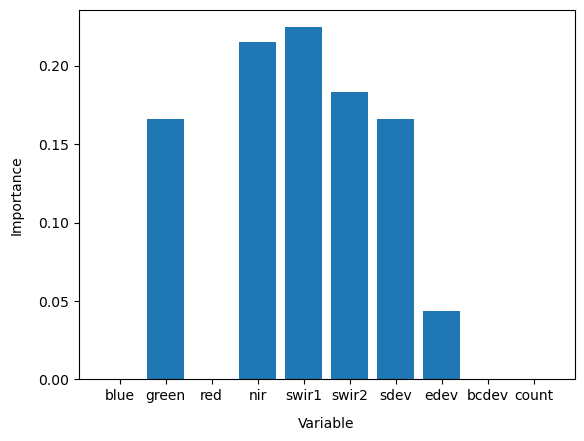

In [20]:
# This shows the feature importance of the input features for predicting the class labels provided
plt.bar(x=model_variables, height=model.feature_importances_)
plt.gca().set_ylabel('Importance', labelpad=10)
plt.gca().set_xlabel('Variable', labelpad=10);

This decision tree representation visualises the trained model. 
Here we can see that the model decides which landcover class to assign based on the value of the important variables in the plot above.

The **gini** value shown in the tree represents the decrease in node impurity.
This can also be understood as how heterogeneous the labels are (small values indicating better results). 
This metric is used by the decision tree to determine how to split the data into smaller groups.

In [21]:
# # Prepare a dictionary of class names
# class_names = {
#     1: 'Cultivated Terrestrial Vegetated',
#     0: 'Not Cultivated Terrestrial Vegetated'
# }

# # Get list of unique classes in model
# class_codes = np.unique(model_train[:, 0])
# class_names_in_model = [class_names[k] for k in class_codes]

# # Plot decision tree
# dot_data = StringIO()
# tree.export_graphviz(model,
#                      out_file=dot_data,
#                      feature_names=model_variables,
#                      class_names=class_names_in_model,
#                      filled=True,
#                      rounded=True,
#                      special_characters=True)

# graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
# Image(graph.create_png())

### Accuracy

We can use the 20% sample of test data we partitioned earlier to test the accuracy of the trained model on this new, "unseen" data.

An accuracy value of 1.0 indicates that the model was able to correctly predict 100% of the classes in the test data.

In [29]:
""" test our predictions on the model_train data (i.e. all our training data) """
predictions = model.predict(model_train[:, model_col_indices])
accuracy_score(predictions, model_train[:, 0])

1.0

## Prediction

Now that we have a trained model, we can load new data and use the `predict_xr` function to predict landcover classes. 

The trained model can technically be used to classify any dataset or product with the same bands as the data originally used to train the data.
However, it is typically highly advisable to classify data from the same product that the data was originally trained on.


In [23]:
# check crs
input_data.crs

<Derived Projected CRS: EPSG:32755>
Name: WGS 84 / UTM zone 55S
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Between 144°E and 150°E, southern hemisphere between 80°S and equator, onshore and offshore. Australia. Papua New Guinea.
- bounds: (144.0, -80.0, 150.0, 0.0)
Coordinate Operation:
- name: UTM zone 55S
- method: Transverse Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [24]:
# check crs
input_data.unary_union.bounds

(1099540.0, 6985660.0, 1115990.0, 7018980.0)

In [25]:
""" Our crs from ENVI is EPSG:32756 (eastings northings) not  EPSG:3577 (lat long)
so we need to convert it """

import pyproj  # new library to load that reprojects coords

# Define the input coordinate system (WGS 84, which is common for GPS coordinates)
input_crs = pyproj.CRS("EPSG:32755")

# Define the output UTM coordinate system (e.g., UTM Zone 33N with WGS 84 datum)
output_crs = pyproj.CRS("EPSG:4326")  # https://epsg.io/32756  #20356    #7856

# Create a pyproj Transformer for the conversion
transformer = pyproj.Transformer.from_crs(input_crs, output_crs, always_xy=True)

# Get extent from input shapefile
xmin, ymin, xmax, ymax = input_data.unary_union.bounds

# Convert coordinates
lon_min, lat_min = transformer.transform(xmin, ymin)
lon_max, lat_max = transformer.transform(xmax, ymax)

# Convert coordinates
#utm_easting, utm_northing = transformer.transform(longitude, latitude)

print("lon_min:", lon_min)
print("lon_max:", lon_max)
print("lat_min:", lat_min)
print("lat_max:", lat_max)

lon_min: 153.04274490357125
lon_max: 153.1913274655799
lat_min: -27.121495865445663
lat_max: -26.815204672129823


In [26]:
# Set up the query parameters
query = {
    'time': time,
    'x': (lon_min, lon_max),
    'y': (lat_min, lat_max),
    'crs': output_crs,
    'resolution': resolution
}

# Use custom function to generate input data
new_input_data = custom_function(query)

Once the data has been loaded, we can classify it using DEA [predict_xr](../Tools/dea_tools/classification.py) function:

In [27]:
new_input_data

<xarray.Dataset>
Dimensions:      (time: 1, y: 1211, x: 669)
Coordinates:
  * time         (time) datetime64[ns] 2022-07-02T11:59:59.999999
  * y            (y) float64 -3.076e+06 -3.076e+06 ... -3.112e+06 -3.112e+06
  * x            (x) float64 2.052e+06 2.052e+06 ... 2.072e+06 2.072e+06
    spatial_ref  int32 3577
Data variables:
    blue         (time, y, x) int16 319 298 282 258 266 ... 316 316 324 324 326
    green        (time, y, x) int16 489 466 429 406 417 ... 294 294 302 300 302
    red          (time, y, x) int16 436 419 392 368 346 ... 144 144 152 152 152
    nir          (time, y, x) int16 2175 2145 2175 2270 2424 ... 85 85 91 91 90
    swir1        (time, y, x) int16 1527 1458 1329 1215 1250 ... 58 57 62 62 62
    swir2        (time, y, x) int16 750 721 638 557 558 547 ... 47 47 51 50 50
    sdev         (time, y, x) float32 0.001821 0.001058 ... 0.007119 0.006883
    edev         (time, y, x) float32 278.7 277.7 276.3 ... 135.7 135.6 137.9
    bcdev        (time, y, x) float32 0.04889 0.05171 0.04867 ... 0.1708 0.1734
    count        (time, y, x) int16 12 11 11 11 10 9 9 ... 16 16 16 16 17 17 17
Attributes:
    crs:           epsg:3577
    grid_mapping:  spatial_ref

In [28]:
model.fit(model_train[:,model_col_indices], model_train[:, 0])

# Make predicition
prediction = model.predict(model_train[:,model_col_indices])

In [30]:
# Predict landcover using the trained model
predicted = predict_xr(model, new_input_data, clean=True)
print('complete')

predicting...
complete


In [ ]:
# #random forest 
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.metrics import accuracy_score
# from sklearn.model_selection import train_test_split
# from sklearn.ensemble import RandomForestRegressor

# # Create a random forest regressor
# rf = RandomForestRegressor(n_estimators=50)
# rf = RandomForestClassifier(n_estimators=50)
# model = RandomForestClassifier(n_estimators=50)

# model.fit(model_train[:,model_col_indices], model_train[:, 0])

# # Make predicition
# prediction = model.predict(model_train[:,model_col_indices])

# # Predict landcover using the trained model
# predicted = predict_xr(model, new_input_data, clean=True)
# print('complete')

## Plotting

To qualitatively evaluate how well the classification performed, we can plot the classifed/predicted data next to our input satellite imagery.

> **Note:** The output below is unlikely to be optimal the first time the classification is run.
The model training process is one of experimentation and assumption checking that occurs in an iterative cycle - you may need to revisit the steps above and make changes to model parameters or input training data until you achieve a satisfactory result.

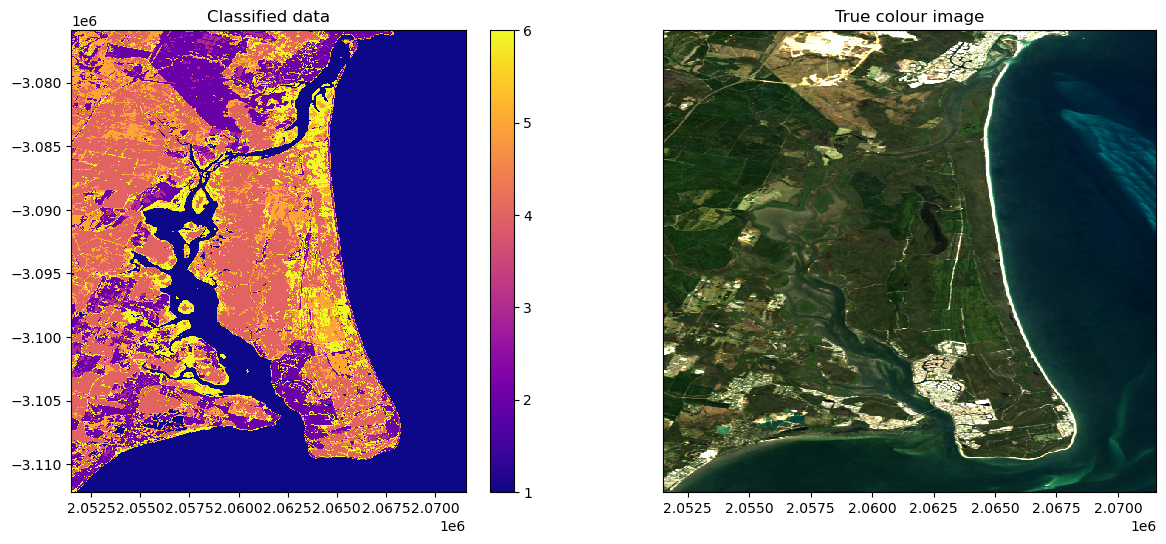

In [31]:
# Set up plot - for first desicion tree 
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot classified image
predicted.Predictions.plot(ax=axes[0], 
               cmap='plasma', 
               add_labels=False, 
               add_colorbar=True)

# Plot true colour image
(new_input_data[['red', 'green', 'blue']]
 .squeeze('time')
 .to_array()
 .plot.imshow(ax=axes[1], robust=True, add_labels=False))

# Remove axis on right plot
axes[1].get_yaxis().set_visible(False)

# Add plot titles
axes[0].set_title('Classified data')
axes[1].set_title('True colour image');

In [ ]:
# Set up plot - for second random forest
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot classified image
predicted.Predictions.plot(ax=axes[0], 
               cmap='plasma', 
               add_labels=False, 
               add_colorbar=True)

# Plot true colour image
(new_input_data[['red', 'green', 'blue']]
 .squeeze('time')
 .to_array()
 .plot.imshow(ax=axes[1], robust=True, add_labels=False))

# Remove axis on right plot
axes[1].get_yaxis().set_visible(False)

# Add plot titles
axes[0].set_title('Classified data')
axes[1].set_title('True colour image');

## Exporting classification
We can now export the predicted landcover out to a GeoTIFF `.tif` file. 
This file can be loaded into GIS software (e.g. QGIS, ArcMap) to be inspected more closely.

In [ ]:
# Write the predicted data out to a GeoTIFF
write_cog(predicted.Predictions,
          'predicted_rf.tif',
           overwrite=True)

## Calculating area of mangroves and salmarshes

In [ ]:
# Constants for calculating 
pixel_length = resolution[1]  # in metres
m_per_km = 1000  # conversion from metres to kilometres

# Area per pixel
area_per_pixel = pixel_length ** 2 / m_per_km ** 2

# Calculate areas
#burnt_area = burnt.sum() * area_per_pixel
mangroves = ?.sum() * area_per_pixel
saltmarsh = ?.sum() * area_per_pixel
 
print(f'mangroves:              {mangroves.item():.2f} km^2')
print(f'saltmarsh:              {saltmarsh.item():.2f} km^2')

***

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Australia data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/GeoscienceAustralia/dea-notebooks).

**Last modified:** May 2022

**Compatible datacube version:** 

In [ ]:
print(datacube.__version__)

## Tags
Browse all available tags on the DEA User Guide's [Tags Index](https://docs.dea.ga.gov.au/genindex.html)